# Lab 0: Introduction to Reddit Data

In this lab, we'll cover:
- What reddit data look like
- Several ways to summarize the conversation's tone
- Evaluation of data over time

In [2]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
#read the data
um_comments = pd.read_csv('data/merged/uofm.tsv', sep='\t')
#convert our dates to the date data type
um_comments['date'] = pd.to_datetime(um_comments.date)
#show the shape of our table
um_comments.shape

(67699, 29)

In [4]:
#Group the comments by month
monthly = um_comments.resample('M', on='date')

In [7]:
exams = pd.read_csv('data/UM_academic_calendar_no_summer.tsv', sep='\t')
exams['date'] = pd.to_datetime(exams.date)
exams.tail()

,event,times,date,exams,class_start,class_stop
325,Classes resume 8:00 a.m.,"Nov 26, Mon",2018-11-26,0,1,0
326,Classes end,"Dec 11, Tues",2018-12-11,0,0,1
327,Study Days,"Dec 12, Wed & Dec 15-16, Sat-Sun",2018-12-12,0,0,0
328,Examinations,"Dec 13-14, Thur-Fri & Dec 17-20, Mon-Thur",2018-12-13,1,0,0
329,Commencement,"Dec 16, Sun",2018-12-16,0,0,0


#### Helper functions
- Don't worry about how this code works, just run it and scroll down.

In [9]:
def center_on_dates(comments, dates, window_size=14):
    subset = []
    for d in dates.date:
        start = d - pd.Timedelta(window_size, unit='d')
        end = d + pd.Timedelta(window_size+1, unit='d')
        tmp = comments[(comments.date >= start) & 
                          (comments.date <= end)].copy()
        tmp['days'] = tmp.date.apply(lambda x: (x - d).days)
        subset.append(tmp)

    subset = pd.concat(subset)
    return subset.groupby(by='days')

In [10]:
exam_weeks = center_on_dates(um_comments, exams)

In [67]:
plt.style.use('fivethirtyeight')
plt.rcParams.update({'font.size': 20, 
                     'legend.fontsize': 'large', 
                     'xtick.labelsize': 'medium'})

def make_plot3(grouped, columns='id', title=None, 
               top=None, bottom=None, colors='UM',
               agg='mean', names = None, 
               line_label='Game Day', x_label='Days from Game Day'):
    
    color_sets = {'UM': ['#024794', '#ffcb05', '#83b2a8',
                         '#989c97', '#7a121c'],
                  'vega': ['#1f77b4', '#ff7f0e', '#2ca02c', 
                           '#d62728', '#9467bd', '#8c564b',
                           '#e377c2', '#7f7f7f', '#bcbd22']}
    
    fig, axs = plt.subplots(figsize=(14,10))
    if bottom is not None:
        axs.set_ylim(bottom=bottom)
    if top is not None:
        axs.set_ylim(top=top)
                
    if isinstance(columns, str):
        columns = [columns]
    
    if not isinstance(grouped, list):
        grouped = [grouped]
        names=['']
        
    scheme = color_sets[colors]
          
    axs.axvline(0, color='k', linestyle='dashed', alpha=.5)
    
    i = 0
    for g, n in zip(grouped, names):
        for c in columns:
            means = g[c].mean()
            sems = g[c].sem()
            axs.plot(means.index, means, color=scheme[i],
                     label=n)
            axs.fill_between(sems.index, means-(1.96*sems), 
                             means+(1.96*sems), 
                             color=scheme[i], alpha=0.5)
            i += 1

        if title is None:
            title = 'Average with 95% confidence interval'

    axs.set_title(title)
    axs.set_xlabel(x_label)
    axs.set_ylabel('Average Sentiment')
    if len(grouped)>1:
        axs.legend(loc='lower left')
    
    axs.text(0.1, axs.get_ylim()[1]-.01, 
            line_label)
    axs.grid(False)
    fig.set_facecolor('white')
    axs.edgecolor = 'white'
    axs.set_facecolor('white')
    plt.tight_layout()
    plt.savefig(line_label+'_sentiment.pdf', facecolor=fig.get_facecolor(), edgecolor='none' )
    plt.savefig(line_label+'_sentiment.png', facecolor=fig.get_facecolor(), edgecolor='none')
    plt.savefig(line_label+'_sentiment.eps', facecolor=fig.get_facecolor(), edgecolor='none')
    plt.show()
    return

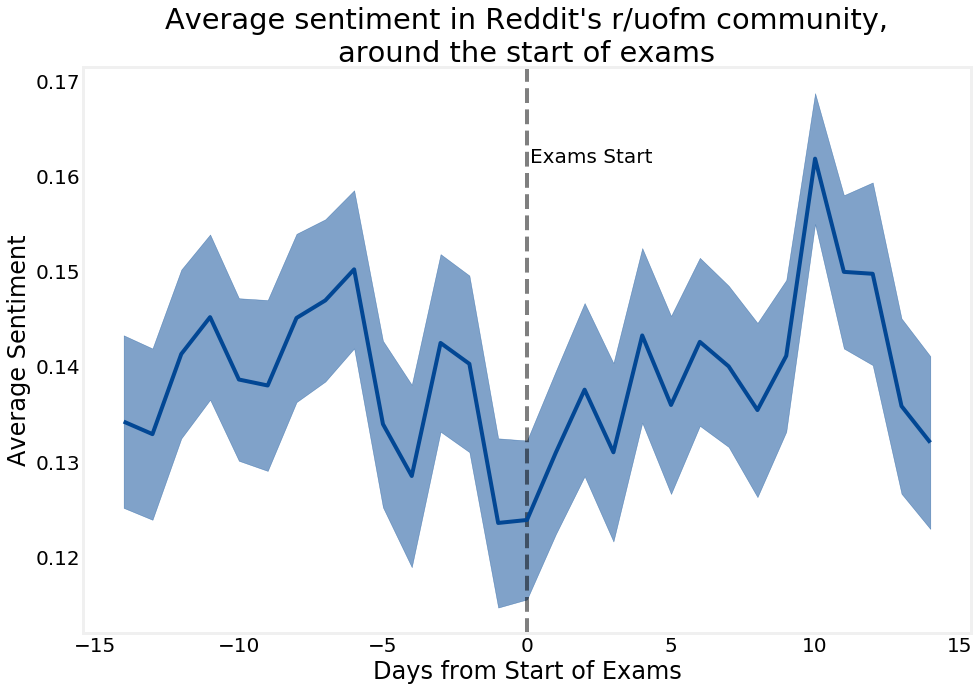

In [68]:
ti = "Average sentiment in Reddit's r/uofm community,\n"
ti += "around the start of exams"

make_plot3(exam_weeks, columns=['sentiment'], colors='UM',
           x_label = 'Days from Start of Exams',
           title = ti,
           line_label='Exams Start')

### Football games
- Load data from the subreddit for UM athletics, `r/MichiganWolverines`, and the dates of football games.

In [69]:
sports_comments = pd.read_csv('data/merged/MichiganWolverines.tsv', 
                              sep='\t')
sports_comments['date'] = pd.to_datetime(sports_comments.date)

games = pd.read_csv('data/UM_football.tsv', sep='\t')
games['date'] = pd.to_datetime(games.date)

win_days = center_on_dates(sports_comments, 
                           games[games.game_result == 'W'], 
                           window_size=7)
loss_days = center_on_dates(sports_comments, 
                           games[games.game_result == 'L'], 
                           window_size=7)

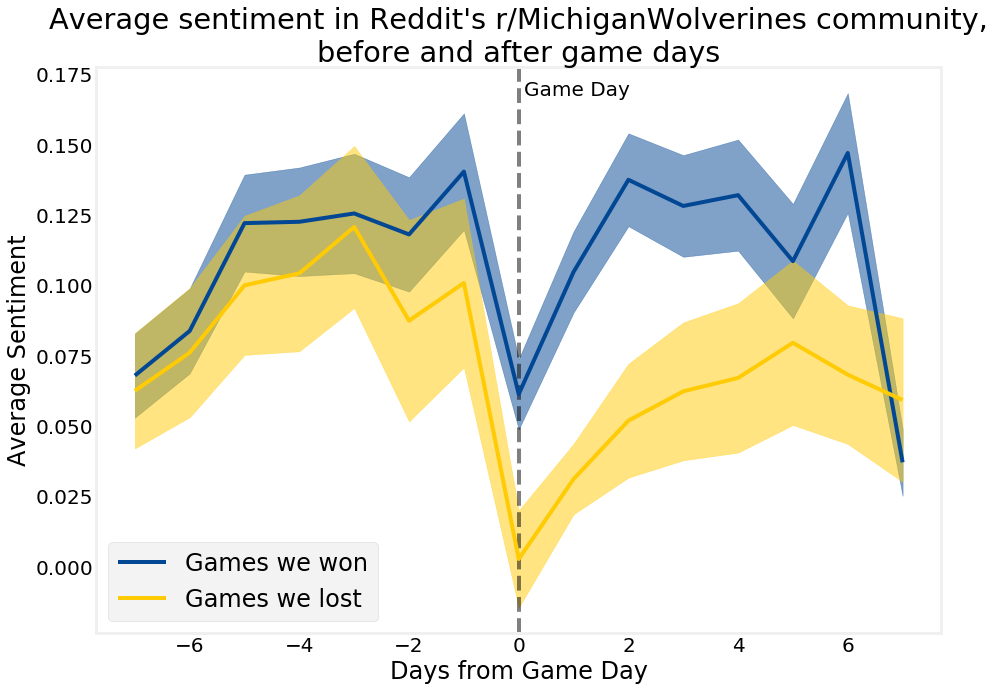

In [70]:
ti = "Average sentiment in Reddit's r/MichiganWolverines community,\n"
ti += "before and after game days"

make_plot3([win_days, loss_days], 
           names=['Games we won', 'Games we lost'],
           columns='sentiment', 
           colors='UM',
           title=ti)